**kaggle notebook file**

[kaggle notebook file](https://www.kaggle.com/code/godaebbang/notebooke24d43d57e?scriptVersionId=180390997)

**최종 결과**

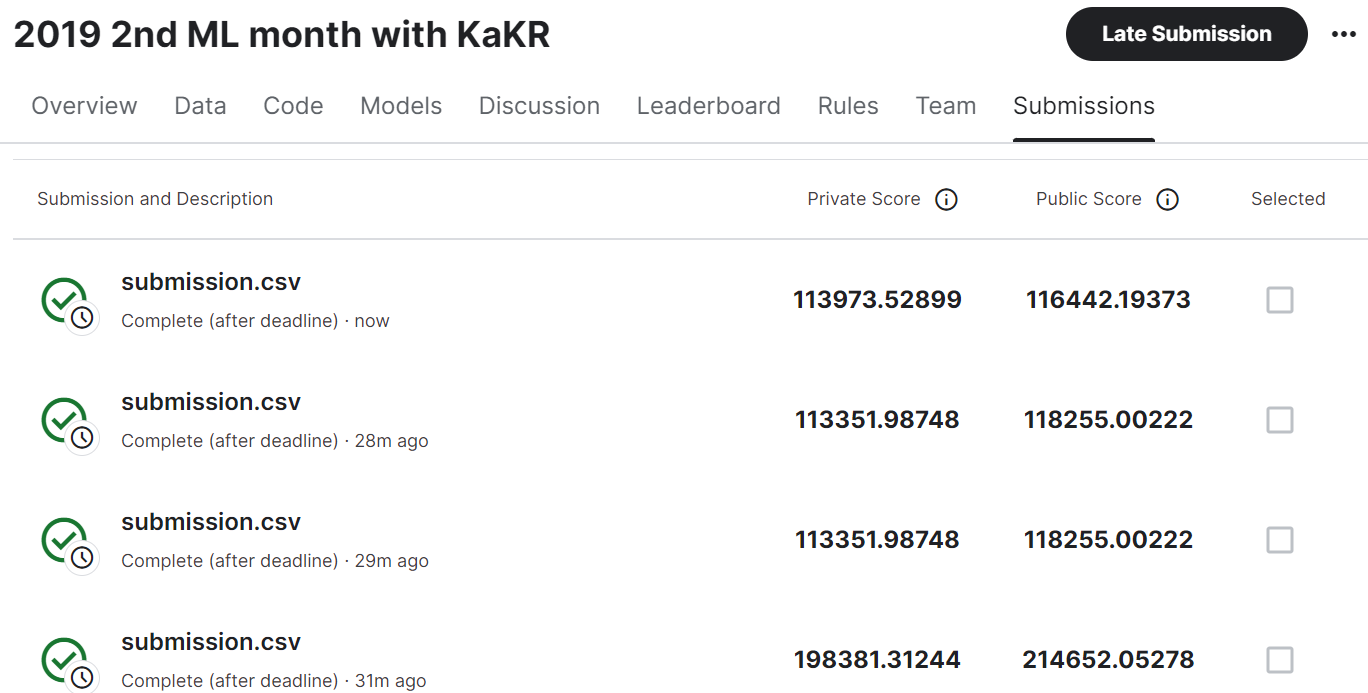

**프로젝트 회고**

이번에 데이터 전처리를 하느라 시간 안에 모델을 만들기 부족했다.

하지만 얻은 것도 있었는데, 함수로 한번에 처리하는 방법과

캐글에서 baseline, 어떻게 모델 성능을 향상시키는지 알 수 있었다.

이를 바탕으로 다양한 캐글 대회에 나가야겠다는 생각을 하게 되었다.

In [49]:
# 라이브러리 불러오기
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [50]:
# 데이터 불러오기
train_df = pd.read_csv('/content/drive/MyDrive/07. GoData/01. kaggle_housing/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/07. GoData/01. kaggle_housing/test.csv')

In [51]:
# 날짜 변환 및 추가 피처 생성
train_df['date'] = pd.to_datetime(train_df['date'])
train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df.drop(columns=['date'], inplace=True)

test_df['date'] = pd.to_datetime(test_df['date'])
test_df['year'] = test_df['date'].dt.year
test_df['month'] = test_df['date'].dt.month
test_df.drop(columns=['date'], inplace=True)

In [52]:
# 건축 후 경과 연수 계산
train_df['age'] = train_df.apply(lambda row: row['yr_renovated'] if row['yr_renovated'] > 0 else row['yr_built'], axis=1)
train_df['age'] = 2023 - train_df['age']
train_df.drop(columns=['yr_built', 'yr_renovated'], inplace=True)

test_df['age'] = test_df.apply(lambda row: row['yr_renovated'] if row['yr_renovated'] > 0 else row['yr_built'], axis=1)
test_df['age'] = 2023 - test_df['age']
test_df.drop(columns=['yr_built', 'yr_renovated'], inplace=True)

In [53]:
# 이상치 제거
train_df = train_df[train_df['bedrooms'] < 10]
train_df = train_df[train_df['bathrooms'] < 8]

In [54]:
# 로그 변환
train_df['price'] = np.log1p(train_df['price'])

# 피처 및 타겟 설정
# 모델 학습을 위해 피처와 타겟 변수를 설정합니다.
X = train_df.drop(columns=['id', 'price'])
y = train_df['price']
# 테스트 데이터에서는 ID 컬럼을 삭제합니다.
X_test = test_df.drop(columns=['id'])

# 학습 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 피처 스케일링 및 결측값 처리
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns

preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

X_train[numeric_features] = preprocessor.fit_transform(X_train[numeric_features])
X_val[numeric_features] = preprocessor.transform(X_val[numeric_features])
X_test[numeric_features] = preprocessor.transform(X_test[numeric_features])

# 데이터프레임 확인
X_train.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,age
1068,-1.526429,-1.453042,-1.147451,-0.148828,-0.926698,-0.082864,-0.305843,-0.626500,-1.404387,-0.917052,-0.660711,1.266359,-0.576330,-0.895352,-0.737305,-0.165941,2014,7,0.598830
14039,-0.411579,1.489753,2.126299,-0.205567,0.933660,-0.082864,-0.305843,-0.626500,1.993440,2.211401,0.252642,0.497774,0.765050,-0.435751,-0.476373,-0.229635,2015,1,-1.127197
9045,-0.411579,0.508822,-0.012551,-0.157638,0.933660,-0.082864,-0.305843,0.915574,0.294526,0.334329,-0.660711,-1.433062,-1.819825,0.059204,0.117972,-0.126837,2014,8,-0.574869
2470,0.703272,0.508822,1.002312,-0.100122,-0.926698,-0.082864,-0.305843,0.915574,0.294526,-0.291361,2.650192,-0.720715,-0.189867,-0.089283,0.567355,-0.068039,2014,12,0.150063
11620,-0.411579,-1.453042,-0.994676,-0.180575,-0.926698,-0.082864,-0.305843,0.915574,-0.554930,-0.748596,-0.660711,-0.439525,-0.711918,0.172336,-0.809786,-0.172972,2014,8,0.150063


In [55]:
# 모델 초기화
lgbm = LGBMRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)

# 하이퍼파라미터 그리드 설정
lgbm_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'num_leaves': [31, 62]
}

xgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7]
}

rf_param_grid = {
    'n_estimators': [100, 200],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [None, 10, 20]
}

# GridSearchCV를 사용하여 모델 최적화
lgbm_grid = GridSearchCV(lgbm, lgbm_param_grid, cv=3, scoring='neg_mean_squared_log_error', n_jobs=-1)
xgb_grid = GridSearchCV(xgb, xgb_param_grid, cv=3, scoring='neg_mean_squared_log_error', n_jobs=-1)
rf_grid = GridSearchCV(rf, rf_param_grid, cv=3, scoring='neg_mean_squared_log_error', n_jobs=-1)

# 모델 학습
lgbm_grid.fit(X_train, y_train)
xgb_grid.fit(X_train, y_train)
rf_grid.fit(X_train, y_train)

# 최적의 하이퍼파라미터
best_lgbm = lgbm_grid.best_estimator_
best_xgb = xgb_grid.best_estimator_
best_rf = rf_grid.best_estimator_

# 평가
lgbm_pred = best_lgbm.predict(X_val)
xgb_pred = best_xgb.predict(X_val)
rf_pred = best_rf.predict(X_val)

# RMSLE 계산
lgbm_rmsle = np.sqrt(mean_squared_log_error(y_val, lgbm_pred))
xgb_rmsle = np.sqrt(mean_squared_log_error(y_val, xgb_pred))
rf_rmsle = np.sqrt(mean_squared_log_error(y_val, rf_pred))

lgbm_rmsle, xgb_rmsle, rf_rmsle

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2251
[LightGBM] [Info] Number of data points in the train set: 12024, number of used features: 19
[LightGBM] [Info] Start training from score 13.047452


(0.011626741001901428, 0.011701111995164692, 0.012549540493828566)

In [56]:
# 교차 검증 설정 및 평가
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_lgbm = cross_val_score(best_lgbm, X, y, cv=kf, scoring='neg_mean_squared_log_error')
cross_val_xgb = cross_val_score(best_xgb, X, y, cv=kf, scoring='neg_mean_squared_log_error')
cross_val_rf = cross_val_score(best_rf, X, y, cv=kf, scoring='neg_mean_squared_log_error')

# 앙상블 모델 설정 및 학습
voting_regressor = VotingRegressor(
    estimators=[
        ('lgbm', best_lgbm),
        ('xgb', best_xgb),
        ('rf', best_rf)
    ]
)
voting_regressor.fit(X_train, y_train)

# 테스트 데이터에 대한 예측
final_predictions = voting_regressor.predict(X_test)

# 예측 값을 원래 스케일로 변환
final_predictions = np.expm1(final_predictions)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2246
[LightGBM] [Info] Number of data points in the train set: 12024, number of used features: 19
[LightGBM] [Info] Start training from score 13.047452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 12025, number of used features: 19
[LightGBM] [Info] Start training from score 13.047430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

In [57]:
# 테스트 데이터셋에 대해 최적의 LGBM 모델을 사용하여 예측 수행
final_predictions = best_lgbm.predict(X_test)

# 예측 값을 원래 스케일로 변환
final_predictions = np.expm1(final_predictions)

# 제출 파일 생성
submission = pd.DataFrame({'id': test_df['id'], 'price': final_predictions})

# 제출 파일 저장
submission.to_csv('submission.csv', index=False)